# Model Experimentation

1. Random Forest Regressor
2. XGBoost Regressor
3. <b>LightGBM Regressor</b>

## Import Libraries

In [1]:
# dataframe packages
import pandas as pd
import numpy as np
from skopt.space import Categorical, Integer, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

# statistical packages
import math
from scipy.stats import uniform
from math import sqrt

# modeling packages
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# evaluation packages
from sklearn.metrics import r2_score,mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# scaling packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# visualisation packages
import seaborn as sns
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
directory = 'C:/Users/chery/Documents/NUS Y4 Sem 2 Modules/BT4222/Dataset/Primary Dataset/modelling_dataset.csv'
model_df = pd.read_csv(directory)

In [3]:
model_df.head()

,Area (SQM),Unit Price ($ PSM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
0,95.0,6316.0,1.0,124.3,33,705.752731,1207.822015,87.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,138.0,13833.0,1.0,124.3,58,1233.947139,768.529003,88.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,99.0,8990.0,10.0,124.3,50,1039.586179,816.818037,80.0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,111.0,6306.0,6.0,124.3,33,509.516515,501.364218,80.0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,122.0,13934.0,10.0,124.3,58,1253.733260,554.491114,88.0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Train Test Split

1. Training set 0.6
2. Validation set 0.2
3. Test set - 0.2

The output variable will be <b>Unit Price ($ PSM)</b>

In [4]:
X = model_df.drop(["Unit Price ($ PSM)"], axis=1)
y = model_df['Unit Price ($ PSM)']

print('Shape of X is:', X.shape)
print('Shape of Y is:', y.shape)

Shape of X is: (54674, 52)
Shape of Y is: (54674,)


Instantiate TimeSeriesSplit

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

print('Shape of X_train is:', X_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of X_test is:', X_test.shape)
print('Shape of y_test is:', y_test.shape)

Shape of X_train is: (38271, 52)
Shape of y_train is: (38271,)
Shape of X_test is: (16403, 52)
Shape of y_test is: (16403,)


## Scaling 

In [7]:
all_features = list(X_train.columns)

standardScale_vars = ['Area (SQM)',
                      'Floor Number',
                      'PPI',
                      'Average Cases Per Year',
                      'Nearest Primary School',
                      'nearest_station_distance']

minMax_vars = ['Remaining Lease']

remaining_features = [x for x in all_features if x not in standardScale_vars and x not in minMax_vars]

In [8]:
s_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

s_scaled = pd.DataFrame(s_scaler.fit_transform(X_train.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_train.index)
mm_scaled = pd.DataFrame(mm_scaler.fit_transform(X_train.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_train.index)

X_train = pd.concat([s_scaled, 
                     mm_scaled,
                     X_train.loc[:, remaining_features].copy()], axis=1)
X_train

,Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,Bishan,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
11187,0.291530,-0.109176,-0.236229,0.243812,-0.771624,1.226898,0.745098,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18593,-1.125873,0.371998,0.210453,0.125051,-0.570640,1.231468,0.725490,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27013,-1.238366,5.785202,-0.452365,0.995966,1.801408,-1.015899,0.764706,0,0,0,...,0,1,0,1,0,0,1,1,1,0
39116,-0.248433,0.973465,0.109589,0.243812,-0.861865,-0.889309,0.764706,0,0,0,...,0,0,0,0,1,1,0,0,0,0
6042,-0.113442,3.259040,-1.187229,0.006290,-0.716828,-0.836027,0.784314,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,-0.203436,-0.830937,0.628316,-0.943799,-1.218061,-0.237225,0.509804,1,0,0,...,0,0,0,0,0,0,1,0,0,0
54343,-1.125873,-0.951230,1.795452,0.164638,-0.556898,0.062359,0.784314,0,0,0,...,0,0,1,0,0,0,1,0,0,0
38158,-0.945886,-0.830937,0.109589,3.252428,0.204740,-0.494623,0.568627,0,0,0,...,0,1,0,0,0,1,0,0,0,0
860,-0.563412,0.492291,-2.383183,2.896144,-0.041901,-0.749697,0.705882,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [9]:
s_scaled_test = pd.DataFrame(s_scaler.transform(X_test.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_test.index)
mm_scaled_test = pd.DataFrame(mm_scaler.transform(X_test.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_test.index)

X_test = pd.concat([s_scaled_test, 
                     mm_scaled_test,
                     X_test.loc[:, remaining_features].copy()], axis=1)
X_test

,Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,Bishan,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
26109,0.134041,0.011118,-0.149775,0.243812,-0.629690,-0.453873,0.666667,0,0,0,...,0,0,0,0,1,1,0,0,0,1
51446,-0.765898,-0.830937,1.147043,-0.864625,-1.058519,-0.912692,0.823529,0,0,0,...,0,1,0,1,0,0,0,0,0,0
21609,0.224035,-0.349763,1.031770,2.896144,2.509617,0.157013,0.705882,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6390,-0.045947,-0.951230,-1.187229,-0.033297,0.062520,-0.976248,0.843137,0,0,0,...,0,0,0,0,1,0,1,0,0,0
40798,5.983642,3.018453,0.757998,-1.102147,0.138606,-0.501497,0.862745,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7350,1.056478,0.612585,-0.841411,-0.389580,0.018348,0.334854,0.509804,0,0,0,...,0,0,0,1,0,0,0,0,0,0
24268,-0.248433,0.011118,0.440998,-0.349993,0.014873,1.248442,0.627451,0,0,0,...,0,0,0,0,0,0,0,0,1,0
29622,0.089044,-0.470056,-0.855820,0.402161,-0.675015,1.227770,0.647059,0,0,0,...,0,0,0,0,0,0,0,0,0,1
50030,-1.575843,0.492291,1.132634,0.243812,-0.740679,-0.669763,0.882353,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Model Tuning

Split training set into training and evaluation

In [10]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

In [11]:
print('Shape of X_train is:', X_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of X_eval is:', X_eval.shape)
print('Shape of y_eval is:', y_eval.shape)

Shape of X_train is: (30616, 52)
Shape of y_train is: (30616,)
Shape of X_eval is: (7655, 52)
Shape of y_eval is: (7655,)


### LGBM Regressor 

Select hyperparameters

<b>Randomized Search</b>

In [18]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {'num_leaves':[i for i in range(5, 15)], 
                  'max_bin':[i for i in range(50, 75)], 
                  'bagging_fraction':[i/10.0 for i in range(0, 10)], 
                  'bagging_freq':[i for i in range(5, 20)], 
                  'feature_fraction':[i/10.0 for i in range(1, 9)], 
                  'feature_fraction_seed':[i for i in range(5, 15)], 
                  'bagging_seed':[i for i in range(5, 10)], 
                  'min_data_in_leaf':[i for i in range(3, 7)], 
                  'max_depth':[i for i in range(5, 15)]
}

# Instantiate the regressor: lgbm
model = LGBMRegressor(objective='regression', learning_rate=0.1, n_estimators=6500)

# Perform random search: grid_mse
clf = RandomizedSearchCV(model, gbm_param_grid, random_state=0)

# Fit randomized_mse to the data
search = clf.fit(X_train, y_train)

# Print the best parameters and lowest RMSE
from pprint import pprint
pprint(search.best_estimator_.get_params())

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.1, colsampl

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsampl

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] feature_fraction is set=0.4, colsampl

In [34]:
model = LGBMRegressor(objective='regression',
                      num_leaves=11, 
                      learning_rate=0.1,
                      n_estimators=6500, 
                      max_bin = 63,
                      bagging_fraction = 0.7,
                      feature_fraction = 0.6,
                      feature_fraction_seed=11,
                      bagging_seed=4,
                      bagging_freq=10, 
                      min_data_in_leaf=6,
                      max_depth=7)

In [35]:
model.fit(X_train, y_train)
# model.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], early_stopping_rounds=50)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, bagging_seed=4,
              feature_fraction=0.6, feature_fraction_seed=11, max_bin=63,
              max_depth=7, min_data_in_leaf=6, n_estimators=6500, num_leaves=11,
              objective='regression')

In [36]:
predict_price_xgb = model.predict(X_eval)

In [37]:
predict_price_xgb

array([ 9689.29647009,  9553.73520522, 14980.69026436, ...,
       10786.12910604, 19262.98228984,  7636.59503902])

Both <b>y_test</b> (the actual test values) and <b>predict_price</b> (the predicted values) are reshaped in order to compare the model accuracy using the root mean squared error.

In [38]:
y_eval_xgb = np.array(y_eval)
y_eval_xgb = y_eval_xgb.reshape(-1,1)
predict_price_xgb = predict_price_xgb.reshape(-1,1)

### Root Mean Squared Error (RMSE)

In [39]:
eval_mse = mean_squared_error(y_eval_xgb, predict_price_xgb)
rmse = sqrt(eval_mse)
print('RMSE: %f' % rmse)

RMSE: 813.454942


Let’s compare this to the mean value across the test data:

In [40]:
np.mean(y_eval_xgb)

11215.052775963422

In [41]:
print('Size of error is approximately:', float(rmse/np.mean(y_eval_xgb)*100))

Size of error is approximately: 7.253242207446051


### Mean Absolute Percentage Error 

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_xgb = mean_absolute_percentage_error(y_eval_xgb, predict_price_xgb)

In [43]:
print('MAPE:', mape_xgb)

MAPE: 4.446797685417917


### Root Mean Squared Log Error 

In [44]:
eval_msle = mean_squared_log_error(y_eval_xgb, predict_price_xgb)
rmsle = sqrt(eval_msle)
print('RMSLE: %f' % rmsle)

RMSLE: 0.061197


Average house price will be 1.05 times as big as the true value

### Adjusted R^2

In [45]:
adj_r = 1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print('Adjusted R^2: %f' % adj_r)

Adjusted R^2: 0.990403


## Predict on Test Dataset

In [46]:
predict_price = model.predict(X_test)

In [47]:
y_test_xgb = np.array(y_test)
y_test_xgb = y_test_xgb.reshape(-1,1)
predict_test_price = predict_price.reshape(-1,1)

<b>RMSE</b>

In [48]:
test_mse = mean_squared_error(y_test_xgb, predict_test_price)
rmse = sqrt(test_mse)
print('RMSE: %f' % rmse)

RMSE: 836.898860


In [135]:
np.mean(y_test_xgb)

11237.164969822594

In [49]:
print('Size of error is approximately:', float(rmse/np.mean(y_test_xgb)*100))

Size of error is approximately: 7.447597881447969


<b>MAPE</b>

In [50]:
mape_test_xgb = mean_absolute_percentage_error(y_test_xgb, predict_test_price)

In [51]:
print('MAPE:', mape_test_xgb)

MAPE: 4.4805307924814155


<b>RMSLE</b>

In [139]:
test_msle = mean_squared_log_error(y_test_xgb, predict_test_price)
rmsle = sqrt(test_msle)
print('RMSLE: %f' % rmsle)

RMSLE: 0.062004


## Generate Feature Importance 

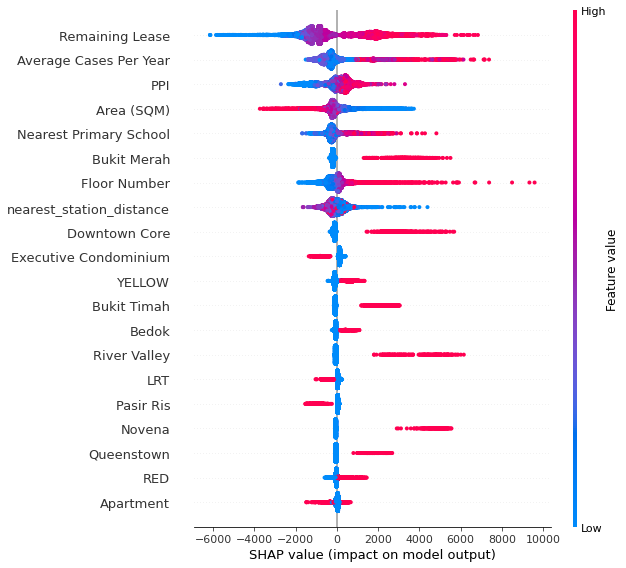

In [140]:
import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

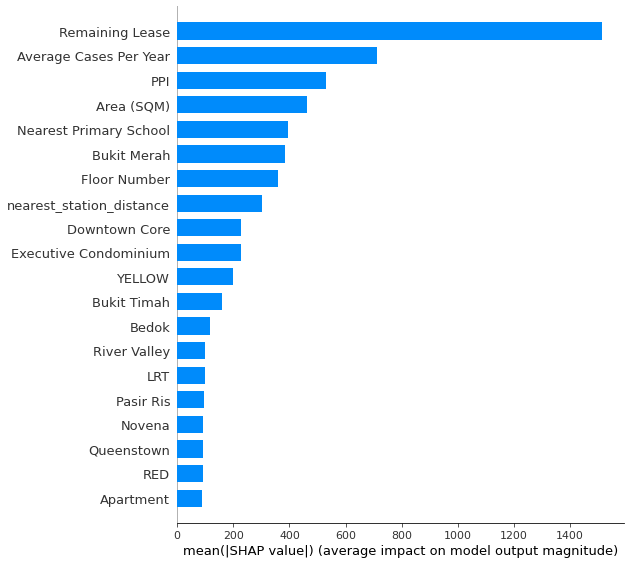

In [141]:
shap.summary_plot(shap_values, X_importance, plot_type='bar')